This file is for evaluating the performance of methods on large tabular datasets.

In [1]:
!echo $HOSTNAME

amueller-4gpu-eastus2-2


In [2]:
import matplotlib.pyplot as plt

from ticl.evaluation.baselines import tabular_baselines

import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore", FutureWarning)  # openml deprecation of array return type
from ticl.datasets import load_openml_list, open_cc_valid_dids, open_cc_dids, open_cc_large_dids
from ticl.evaluation.baselines.tabular_baselines import knn_metric, catboost_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric, hyperfast_metric, hyperfast_metric_tuning, resnet_metric, mothernet_init_metric
from ticl.evaluation.tabular_evaluation import evaluate, eval_on_datasets, transformer_metric
from ticl.evaluation import tabular_metrics
from ticl.prediction.tabpfn import TabPFNClassifier
import os
from ticl.evaluation.baselines.distill_mlp import DistilledTabPFNMLP
from ticl.prediction.mothernet import MotherNetClassifier
from functools import partial
from ticl.evaluation.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from ticl.prediction.mothernet import ShiftClassifier, EnsembleMeta, MotherNetClassifier
from sklearn.impute import SimpleImputer
from ticl.prediction.mothernet_additive import MotherNetAdditiveClassifier

from interpret.glassbox import ExplainableBoostingClassifier


from hyperfast import HyperFastClassifier

# transformers don't have max times
import warnings
import pandas as pd

import datetime

import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Datasets

In [4]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(
    # open_cc_large_dids, 
    [1491, 41986, 42343],
    multiclass=True,
    shuffled=True, 
    filter_for_nan=False, 
    max_samples = 1000000, 
    num_feats=5000, 
    return_capped=True,
    max_num_classes=100,
)

Number of datasets: 3


In [5]:
eval_positions = [5000000]
max_features = 5000
n_samples = 1000000
base_path = os.path.join('../')
overwrite = False
# max_times only affect non-nn models, nn models are not affected by max_times
# for non-nn models, when the runtime is longer than the max_time, it should stop
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60] 
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [6]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [7]:
cc_test_datasets_multiclass_df['isNumeric'] = (
    cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1
    ) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)

In [8]:
cc_test_datasets_multiclass_df['NumberOfInstances'] =  cc_test_datasets_multiclass_df['NumberOfInstances'].astype(int)
cc_test_datasets_multiclass_df['NumberOfFeatures'] =  cc_test_datasets_multiclass_df['NumberOfFeatures'].astype(int)
cc_test_datasets_multiclass_df['NumberOfClasses'] =  cc_test_datasets_multiclass_df['NumberOfClasses'].astype(int)

print(cc_test_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].rename(columns={'NumberOfFeatures': "d", "NumberOfInstances":"n", "NumberOfClasses": "k"}).to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
did & name & d & n & k \\
\midrule
1491 & one-hundred-plants-margin & 65 & 1600 & 100 \\
41986 & GTSRB-HOG01 & 1569 & 51839 & 43 \\
42343 & KDD98 & 478 & 82318 & 2 \\
\bottomrule
\end{tabular}



In [9]:
preview = cc_test_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].reset_index(drop=True)
preview

,did,name,NumberOfFeatures,NumberOfInstances,NumberOfClasses
0,1491,one-hundred-plants-margin,65,1600,100
1,41986,GTSRB-HOG01,1569,51839,43
2,42343,KDD98,478,82318,2


# Method Evaluation
This section runs baselines and saves results locally.

## ResNet

In [14]:
max_times = [60 * 60]
# these will all be evaluated on CPU because they are given as callables, which is a weird way to do it.
clf_dict= {
    'resnet_gpu': resnet_metric
}

results_resnet = [
    eval_on_datasets(
        'multiclass', 
        model, 
        model_name, 
        cc_test_datasets_multiclass, 
        eval_positions=eval_positions, 
        max_times=max_times,
        metric_used=metric_used, 
        split_numbers=[1, 2, 3, 4, 5], # seed indicate how to split the dataset
        n_samples=n_samples, 
        base_path=base_path, 
        n_jobs=1, 
        device="cuda", 
        verbose=0
    )
    for model_name, model in clf_dict.items()
]

evaluating resnet_gpu on cuda


  0%|          | 0/95 [00:00<?, ?it/s]

In [10]:
max_times = [60*60]
split_numbers = [1, 2, 3, 4, 5]

max_times = [10000000]
split_numbers = [1]
fetch_only = False # get the existing result or not 

clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric,
    'mlp': mlp_metric
}

test_baselines = []

results_baselines = [
    eval_on_datasets(
    'multiclass', 
    model, 
    model_name, 
    cc_test_datasets_multiclass, 
    eval_positions=eval_positions, 
    max_times=max_times,
    metric_used=metric_used, 
    split_numbers=split_numbers,
    n_samples=n_samples, 
    base_path=base_path, 
    fetch_only=fetch_only,
    ) for model_name, model in clf_dict.items()
]

evaluating knn on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed: 18.8min remaining: 25.8min


# TabPFN

In [10]:
max_times = [10000000]
device = "cuda"

results_tabpfn = []

tabpfn_models = {
    'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples10000_08_01_2024_20_58_55': ('SSMTabPFN+10000', 'on_exit'),
    'tabpfn_largedatasetTrue_n2048_08_04_2024_23_40_10': ('TabPFN+1000', 1000),
    'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50': ('SSMTabPFN+50000', 110),
    'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples1000_08_02_2024_17_14_16': ('SSMTabPFN+1000', 'on_exit'),
}

for model_string in tabpfn_models:
    model = TabPFNClassifier(
        device=device, 
        model_string=model_string, 
        epoch=tabpfn_models[model_string][1], 
        N_ensemble_configurations=3,
    )

    result = eval_on_datasets(
        'multiclass', 
        model, 
        model_string, 
        cc_test_datasets_multiclass, 
        eval_positions=eval_positions, 
        max_times=max_times,
        metric_used=metric_used, 
        split_numbers=[1, 2, 3, 4, 5],
        n_samples=n_samples, 
        base_path=base_path, 
        overwrite=False, 
        fetch_only=True,
        n_jobs=1, 
        device=device,
    )
    
    results_tabpfn.append(result)

# store the results as pickle
with open(f'{base_path}/results/tabular/multiclass/tabpfn_summary.pkl', 'wb') as f:
    pickle.dump(results_tabpfn, f)
    

evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples10000_08_01_2024_20_58_55 on cuda


100%|██████████| 95/95 [00:01<00:00, 49.97it/s] 


evaluating tabpfn_largedatasetTrue_n2048_08_04_2024_23_40_10 on cuda


100%|██████████| 95/95 [00:01<00:00, 50.86it/s] 


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50 on cuda


100%|██████████| 95/95 [00:01<00:00, 50.89it/s] 


evaluating ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples1000_08_02_2024_17_14_16 on cuda


100%|██████████| 95/95 [00:01<00:00, 50.88it/s] 


# Results Preview

In [11]:
flat_results = []
for per_dataset in results_tabpfn:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [12]:
results_view = results_df[['model', 'dataset', 'fit_time', 'inference_time', 'mean_metric']].copy()
# compute the mean of fit time and inference time across different splits when the model and datasets are the same
# and the rows should be reduced
results_view = results_view.groupby(['model', 'dataset']).mean().reset_index()
results_view



,model,dataset,fit_time,inference_time,mean_metric
0,ssm_tabpfn_b4_largedatasetTrue_modellinear_att...,Amazon_employee_access,0.001740,1.610215,0.582722
1,ssm_tabpfn_b4_largedatasetTrue_modellinear_att...,BNG(tic-tac-toe),0.276581,1.749913,0.830975
2,ssm_tabpfn_b4_largedatasetTrue_modellinear_att...,Click_prediction_small,0.002060,1.558434,0.656008
3,ssm_tabpfn_b4_largedatasetTrue_modellinear_att...,PhishingWebsites,0.000841,1.126524,0.990166
4,ssm_tabpfn_b4_largedatasetTrue_modellinear_att...,adult,0.002316,2.027838,0.904756
...,...,...,...,...,...
67,tabpfn_largedatasetTrue_n2048_08_04_2024_23_40_10,kdd_internet_usage,0.000841,1.325917,0.932817
68,tabpfn_largedatasetTrue_n2048_08_04_2024_23_40_10,kick,0.004950,12.720630,0.650459
69,tabpfn_largedatasetTrue_n2048_08_04_2024_23_40_10,okcupid-stem,0.002514,6.083492,0.823284
70,tabpfn_largedatasetTrue_n2048_08_04_2024_23_40_10,volcanoes-b1,0.000825,0.382716,0.663162


In [13]:
cols = ['fit_time', 'inference_time', 'mean_metric']

# Pivot the table
pivot_table = results_view.pivot(index='dataset', columns='model', values=cols)

# Flatten column names
pivot_table.columns = [f'{col[1]}_{col[0]}' for col in pivot_table.columns]

# Reset index to make 'dataset' a column
pivot_table = pivot_table.reset_index()

columns_mapping = {f'{model_string}_{col}': f'{tabpfn_models[model_string][0]}_{col}' for model_string in tabpfn_models for col in cols}

# Rename columns for clarity
pivot_table = pivot_table.rename(columns=columns_mapping)
pivot_table

,dataset,SSMTabPFN+10000_fit_time,SSMTabPFN+1000_fit_time,SSMTabPFN+50000_fit_time,TabPFN+1000_fit_time,SSMTabPFN+10000_inference_time,SSMTabPFN+1000_inference_time,SSMTabPFN+50000_inference_time,TabPFN+1000_inference_time,SSMTabPFN+10000_mean_metric,SSMTabPFN+1000_mean_metric,SSMTabPFN+50000_mean_metric,TabPFN+1000_mean_metric
0,Amazon_employee_access,0.001740,0.001666,0.001785,0.001644,1.610215,1.539596,1.309624,2.765778,0.582722,0.497746,0.638652,0.600251
1,BNG(tic-tac-toe),0.276581,0.232236,0.228126,0.420541,1.749913,1.523037,1.635155,3.747047,0.830975,0.813772,0.832361,0.822338
2,Click_prediction_small,0.002060,0.001981,0.003712,0.003932,1.558434,1.538357,1.650382,3.820404,0.656008,0.644168,0.680016,0.674380
3,PhishingWebsites,0.000841,0.000948,0.001057,0.000801,1.126524,0.984327,1.149042,0.943847,0.990166,0.987193,0.990868,0.991972
4,adult,0.002316,0.002536,0.002396,0.002429,2.027838,1.747511,2.084496,5.461549,0.904756,0.901032,0.905423,0.900663
5,artificial-characters,0.001066,0.001249,0.001004,0.001067,0.882811,1.105674,0.678908,0.737485,0.942552,0.917270,0.948685,0.961583
6,bank-marketing,0.003249,0.002385,0.002064,0.002098,1.992414,1.906557,2.012559,4.939133,0.900695,0.891449,0.901204,0.893816
7,connect-4,0.003611,0.003927,0.003516,0.003707,3.913979,3.281573,3.465908,11.082792,0.691421,0.602033,0.701240,0.607832
8,elevators,0.001256,0.002862,0.001191,0.001117,1.329836,1.170666,1.060350,1.238578,0.948504,0.946264,0.947827,0.949277
9,higgs,0.004608,0.005006,0.005174,0.004877,4.702443,4.443357,4.634073,22.120060,0.751625,0.722108,0.749937,0.712560


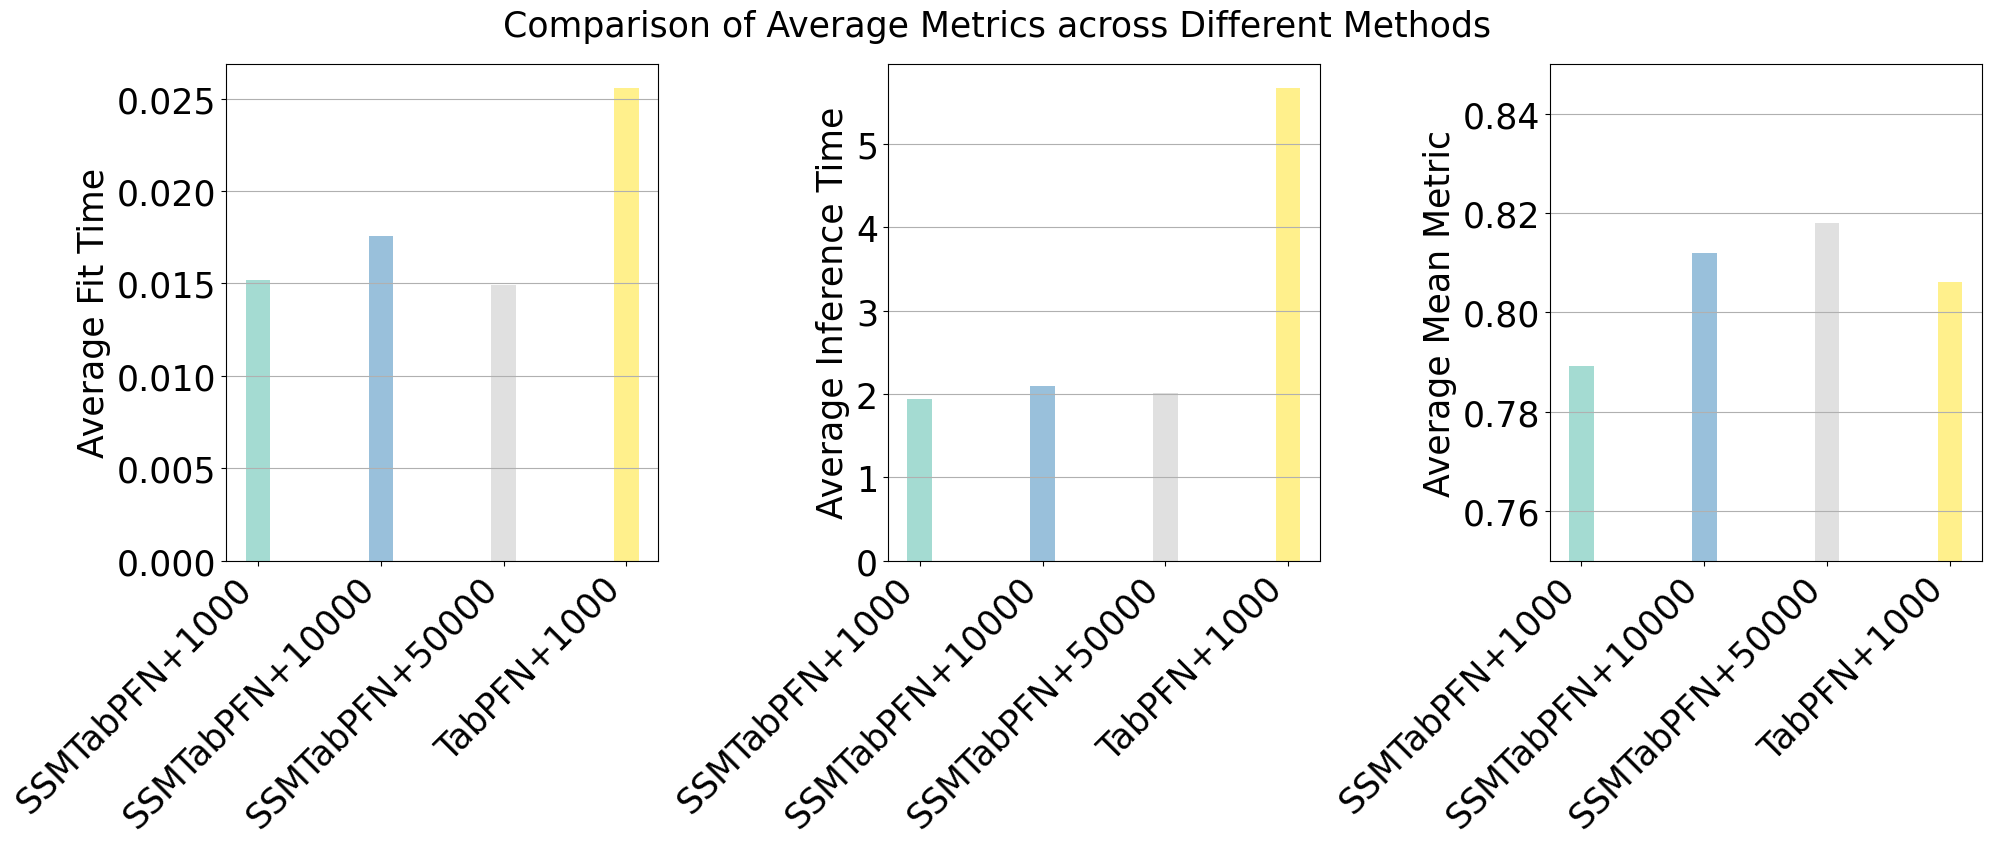

In [17]:
# Calculate averages
metrics = ['fit_time', 'inference_time', 'mean_metric']
methods = ['SSMTabPFN+1000', 'SSMTabPFN+10000', 'SSMTabPFN+50000', 'TabPFN+1000']

averages = {metric: {method: pivot_table[f'{method}_{metric}'].mean() for method in methods} for metric in metrics}

# Prepare for plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
width = 0.2
x = np.arange(len(methods))

# Color map for consistency across subplots
colors = plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(methods)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics):
    ax = axes[i]
    values = [averages[metric][method] for method in methods]
    bars = ax.bar(x, values, width, alpha=0.8, color=colors)
    
    ax.set_ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=25)
    ax.tick_params(axis='y', labelsize=25)
    # ax.set_title(f'Comparison of {metric.replace("_", " ").title()}', fontsize=25)
    ax.set_xticks(x, fontsize=25)
    ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=25)
    ax.yaxis.grid(True)
    
    if i == 2: ax.set_ylim(0.75, 0.85)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        # ax.text(bar.get_x() + bar.get_width()/2., height,
        #         f'{height:.6f}',
        #         ha='center', va='bottom', rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Comparison of Average Metrics across Different Methods', fontsize=25, y=1.05)
plt.show()